# Modeling a Binary Star Population

Below is the code of an astronomy model of a fast-rotating star population found by the Kepler telescope. 

We start by importing all the astronomy files and reading the data.

In [1]:
from astropy.table import Table, join
import astropy.io.ascii as ascii
import astropy.io.fits

def read_data():
    targets = Table.read('MDM_targets.csv', format = 'ascii.csv')
    targets.rename_column('ï»¿KIC', 'KIC')
    data_set1 = Table.read('ajab8a33t1_mrt.txt', format = 'ascii.mrt')
    data_set2 = Table.read('ajab8a33t2_mrt.txt', format = 'ascii.mrt')
    McQuillan = Table.read('McQuillan.fit', format = 'fits')
    
    #Join the datasets
    d1_d2 = join(data_set1, data_set2)
    targets = join(targets, d1_d2)
    table = join(targets, McQuillan, join_type = 'left', keys = 'KIC')
    
    return table

#Save table
def write_data():
    table = read_data()
    table.write('Target_data.csv', format = 'ascii.csv')

#Read table
def read_table():
    
    return Table.read('Target_data.csv')

#Create an index for KIC targets
def KIC_index():
    table = read_data()
    index = table['KIC']
    
    return index

import pickle
#Get observation times and radial velocities
def rv_times(KIC_number):
    with open('full_rvs.pickle', 'rb') as f:
        docs, full_rvs = pickle.load(f)
    KIC_times, KIC_rvs = full_rvs[f"KIC{KIC_number}"]
    
    return KIC_times, KIC_rvs


Now we define functions to return known quanities from our target stars loaded above.

In [2]:
#Target Mass
def target_mass(KIC_number):
    table = read_table()
    target_mass = table['KIC', 'Mass']
    target_mass.add_index('KIC')
    mass = target_mass.loc[KIC_number]['Mass']
    
    return mass

#Target Orbital Period
def target_period(KIC_number):
    table = read_table()
    target_period = table['KIC', 'Prot']
    target_period.add_index('KIC')
    Prot = target_period.loc[KIC_number]['Prot']
    
    return Prot

# Model Unknown Parameters

We start by modeling the inclination angle. The inclination angle is the angle between the plane of the orbit and the observer. The inclination angle of the binary orbit follows a sine distribution, this is because there’s almost an infinite number of ways to have a 90 degree inclination angle but there are only two ways of getting a 0 degree inclination angle.

In [3]:
import numpy as np
from math import pi

# Inclination angle
def sin_distn():
    rand_uniform_array = np.random.uniform(0, pi/2, 300)
    i_angle = np.arccos((2 * rand_uniform_array)/pi)
    
    return i_angle

inclination_angle_array = sin_distn()


Next, we model the mass ratip (q) and phase angle (theta). The mass ratio is the mass of the primary star divided by the mass of the secondary star. The mass ratio follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 1. The phase angle is the angle at which the first observation was made. The phase angle follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 2π. 


In [4]:
# Mass ratio (primary mass / companion mass)
q_array = np.random.uniform(0,1, 200)

from astropy import units as u
#Phase angle
theta_array = np.random.uniform(0,2*pi, 200) * u.radian

# Astronomy Functions

Next we create a function to calculate the amplitude (semi-major axis) of the binary system. 

In [5]:
from astropy import constants as const
Gravitational_constant = const.G # Value = 6.67 x 10^-11 m^3/(kg s^2)

# Amplitude (semi-major axis)
def calculate_amplitude(mass1, q_array, inclination_angle_array, period):
    mass2 = mass1 * q_array
    orbital_period = (period * u.day).to(u.second)
    total_mass = mass1 + mass2
    amplitude = (
        ( ((mass2**3) / (total_mass**2))
        * (np.sin(inclination_angle_array)**3)
        *((2 * pi * Gravitational_constant) / orbital_period))**(1/3)
        )
    return amplitude # units of m/s


In astronomy, radial velocity is an object’s motion towards or away from the observer. Using Kepler’s 3rd law of planetary motion, we create functions to calculate radial velocity, and add white noise to account for errors in observations.

In [6]:
# Radial velocity
def calculate_radial_velocity(mass1, q_array, time_array, period , theta_array, inclination_angle_array):
    time_array = time_array.reshape(len(time_array), 1, 1, 1) 
    theta_array = theta_array.reshape(1, len(theta_array), 1, 1)
    q_array = q_array.reshape(1, 1, len(q_array),1)
    inclination_angle_array = inclination_angle_array.reshape(1, 1, 1, len(inclination_angle_array))
    
    amplitude = calculate_amplitude(mass1, q_array, inclination_angle_array, period)
    period =  period * u.day
    omega = (2*pi)/(period.to(u.second))
    radial_velocity = ((amplitude*np.cos(((omega*time_array).to(u.radian, equivalencies = u.dimensionless_angles())) + theta_array))) #units of m/s
    
    return radial_velocity # in m/s

# Add noise to radial velocity
def calculate_velocity_with_noise(mass1, q_array, time_array, period, std, theta_array, inclination_angle_array):
    radial_velocity_array = calculate_radial_velocity(mass1, q_array, time_array, period,theta_array,inclination_angle_array) #m/s
    noise = np.random.normal(0, std, size = radial_velocity_array.shape)  * (u.km/u.second)
    velocity_with_noise = radial_velocity_array + noise
    
    return (velocity_with_noise.to(u.km/u.s)) 


Next, we generate an array of radial velocities for each possible combination of parameters.

In [7]:
SUN_MASS = const.M_sun # Value = 1.98840987e+30 kg

def generate_rv_array(KICnumber):
    time_array, measured_rv = rv_times(KICnumber)
    time_array = np.array(time_array) *u.day
    measured_rv = np.array(measured_rv) * (u.km/u.s)
    std = 10 # standard deviation in km/s
    mass = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber) 
    rv_array = calculate_velocity_with_noise(mass, q_array, time_array, t_period, std, theta_array, inclination_angle_array) #m/sec
    
    return rv_array # in km/s

We generate a Chi-square value for each radial velocity curve, by comparing it with the actual radial velocity measured by the Kepler telescope.

In [8]:
def Chi_square_distribution(KICnumber):
    radial_velocities = generate_rv_array(KICnumber)
    time_array,measured_rv = rv_times(KICnumber)
    measured_rv = measured_rv * (u.km/u.s) #measured rv
    measured_rv = measured_rv.reshape(len(measured_rv), 1, 1, 1)
    chi_square = ((radial_velocities - measured_rv)**2) / ((10* u.km/u.s)**2)
    chi_values_array = np.sum(chi_square, axis = 0)
    
    return chi_values_array

Next, find the best fit curve which is the one with the lowest chi-square value, and we return the set of parameters that best fits the observed data.

In [9]:
def minimum(KICnumber):
    chi_values = Chi_square_distribution(KICnumber)
    min_value = chi_values.min() #returns the minimum value in the multidimensional array s
    max_value = chi_values.max()
    min_index = np.argwhere(chi_values == min_value)
    
    theta_value = theta_array[min_index[0][0]]
    q_value = q_array[min_index[0][1]]
    i_value = inclination_angle_array[min_index[0][2]]
    
    print(f"KIC target: KIC_{KICnumber}")
    print("max value is ", max_value)
    print("min value is ", min_value)
    print("theta value is ", theta_value)
    print("q value is ", q_value)
    print("inclination angle value is ", i_value)
    
    return [theta_value,q_value,i_value,min_value]

Lastly, we created a function that combines some of the steps described above.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def KIC_Model(KICnumber):
    #Declare paramters
    time_array, measured_rv = rv_times(KICnumber) 
    time_array = np.array(time_array) *u.day
    mass1 = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber)
    
    #Find minimum Chi-Square value and respective modeled parameters
    min_ = minimum(KICnumber)
    b_f_theta = np.array([min_[0].value]) * u.radian
    b_f_q = np.array([min_[1]])
    b_f_i = np.array([min_[2]])
    min_chi_value = np.array([min_[3]])
    #print(b_f_theta,b_f_q,b_f_i)

    #Hypothesis testing
    print('Experimental p value = ', min_chi_value)
    right_tail_value = stats.chi2.ppf(1-0.025, df = 2)#we use 2 degrees of freedom since we have 3 categories of modeled parameters, dof = n-1 = (theta, q, inc_angle) - 1
    print('Theoretical p value =', right_tail_value)
    if min_chi_value < right_tail_value:
        print('We have a binary system')
    elif min_chi_value > right_tail_value:
        print('We do not have a binary system')
    print("")

    
    #calculate best fit curve radial velocity and plot it with measured rv
    b_f_rv = calculate_radial_velocity(mass1, b_f_q, time_array, t_period, b_f_theta, b_f_i)
    sns.set()
    ax = plt.axes()
    ax.set(xlabel = 'time (days)', ylabel = 'radial velocity (km/sec)',
           title = f"KIC_{KICnumber} observed & measured rvs")
    plt.plot(time_array, (b_f_rv[:,0,0,0].to(u.km/u.s)).value, label = 'best fit rv curve', linestyle = ':')
    plt.plot(time_array,measured_rv, label = 'measured rv', linestyle = '-')
    plt.legend()
    plt.show()
    

index = KIC_index()

In [11]:
def Run_Model():
    for i in index:
        KIC_Model(i)

KIC target: KIC_1570924
max value is  1109.6136552787852
min value is  5.7552033249921255
theta value is  1.8402803465424207 rad
q value is  0.06529929791909395
inclination angle value is  0.40504462752160747
Experimental p value =  [5.75520332]
Theoretical p value = 7.377758908227871
We have a binary system



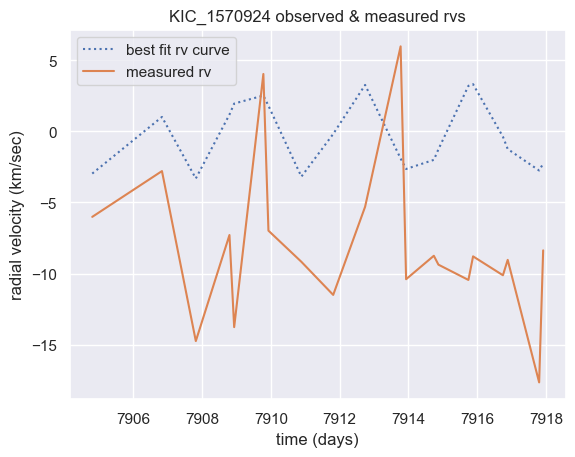

KIC target: KIC_3248885
max value is  1224.4672906268065
min value is  101.76607737678813
theta value is  5.661769379817619 rad
q value is  0.5690395598889717
inclination angle value is  0.35243231745848297
Experimental p value =  [101.76607738]
Theoretical p value = 7.377758908227871
We do not have a binary system



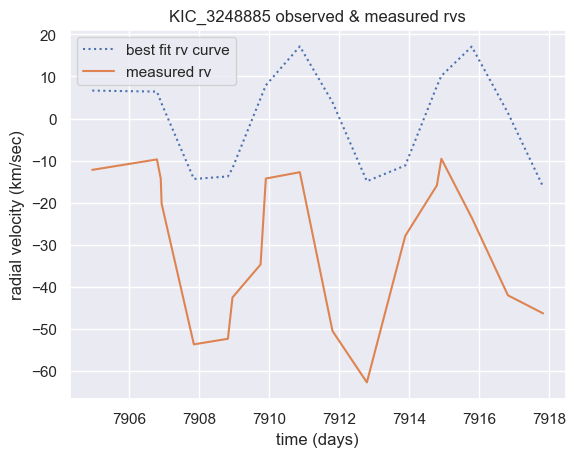

KIC target: KIC_3539632
max value is  1180.0333796121815
min value is  19.630224470488212
theta value is  2.369238113072323 rad
q value is  0.08490992851627044
inclination angle value is  1.178528043634992
Experimental p value =  [19.63022447]
Theoretical p value = 7.377758908227871
We do not have a binary system



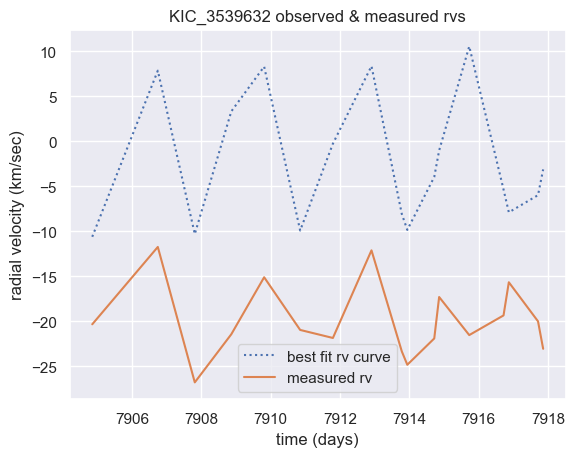

KIC target: KIC_3540728
max value is  1452.9864801638864
min value is  31.928768903363803
theta value is  3.273631782609103 rad
q value is  0.0015563076058796588
inclination angle value is  0.5415270236000886
Experimental p value =  [31.9287689]
Theoretical p value = 7.377758908227871
We do not have a binary system



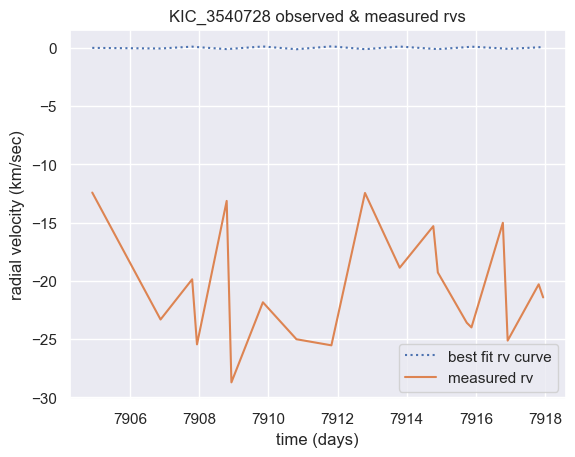

KIC target: KIC_4036736
max value is  1183.6243956674089
min value is  31.33065660053827
theta value is  3.8217506499046534 rad
q value is  0.011173215507754741
inclination angle value is  1.1572303866298916
Experimental p value =  [31.3306566]
Theoretical p value = 7.377758908227871
We do not have a binary system



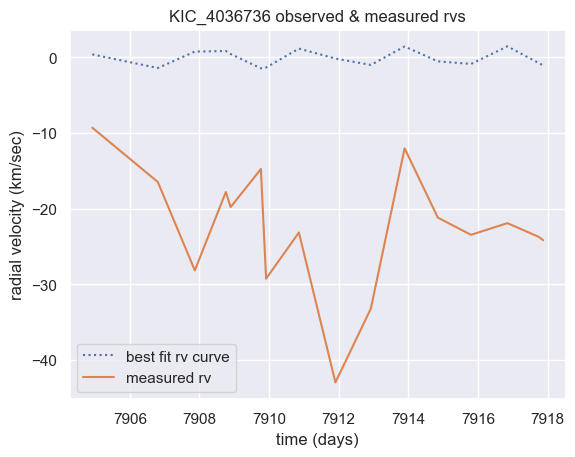

KIC target: KIC_4249702
max value is  930.2295443489828
min value is  30.13932990681233
theta value is  0.5198497385182497 rad
q value is  0.08283732401943
inclination angle value is  1.14314535916987
Experimental p value =  [30.13932991]
Theoretical p value = 7.377758908227871
We do not have a binary system



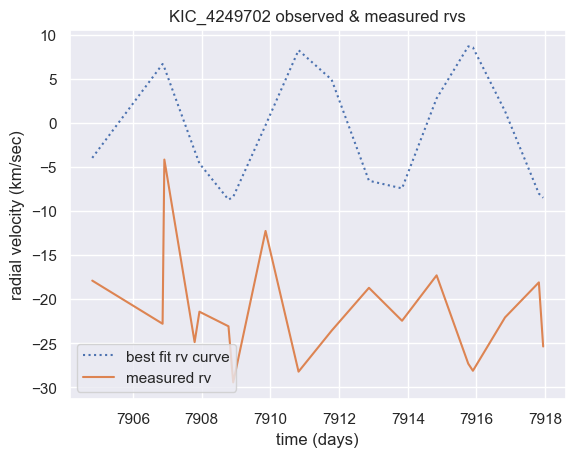

KIC target: KIC_4454890
max value is  1604.7732464520866
min value is  44.12760781929579
theta value is  2.488800028353508 rad
q value is  0.016388957015040395
inclination angle value is  0.8177890070111251
Experimental p value =  [44.12760782]
Theoretical p value = 7.377758908227871
We do not have a binary system



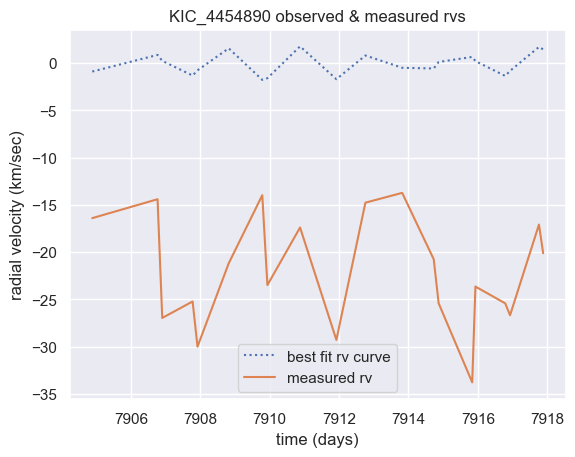

KIC target: KIC_4480434
max value is  1173.892016755432
min value is  63.13594763398454
theta value is  3.271702028090157 rad
q value is  0.05041391399006678
inclination angle value is  0.22252086188882952
Experimental p value =  [63.13594763]
Theoretical p value = 7.377758908227871
We do not have a binary system



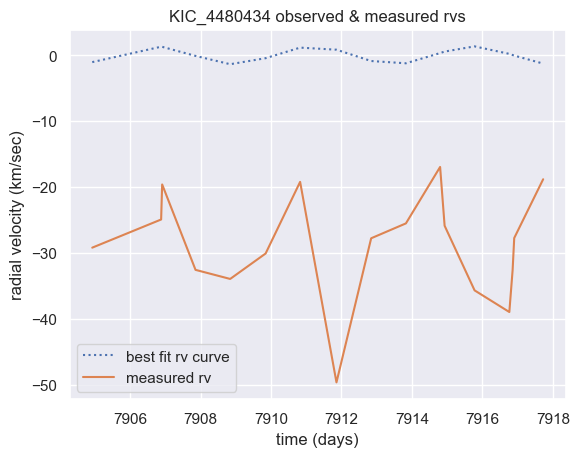

KIC target: KIC_5213142
max value is  1183.0432941596432
min value is  3.6598635984290446
theta value is  1.1052203137042809 rad
q value is  0.22415099900273983
inclination angle value is  0.23508303050241713
Experimental p value =  [3.6598636]
Theoretical p value = 7.377758908227871
We have a binary system



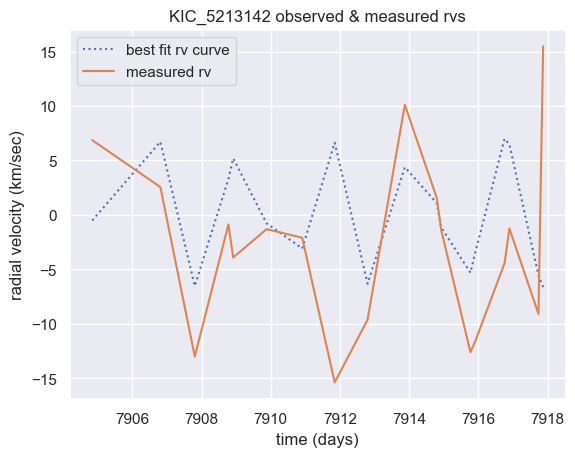

KIC target: KIC_5553362
max value is  1048.7836736768556
min value is  19.865791688878254
theta value is  2.2599264899975178 rad
q value is  0.09995445504437406
inclination angle value is  0.8249862660562447
Experimental p value =  [19.86579169]
Theoretical p value = 7.377758908227871
We do not have a binary system



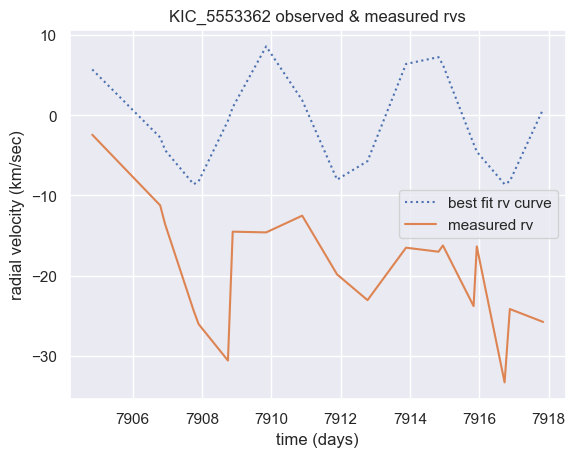

KIC target: KIC_6425783
max value is  1048.2104261123568
min value is  54.41407089834591
theta value is  3.203124946540936 rad
q value is  0.05529857730513921
inclination angle value is  1.35167268770802
Experimental p value =  [54.4140709]
Theoretical p value = 7.377758908227871
We do not have a binary system



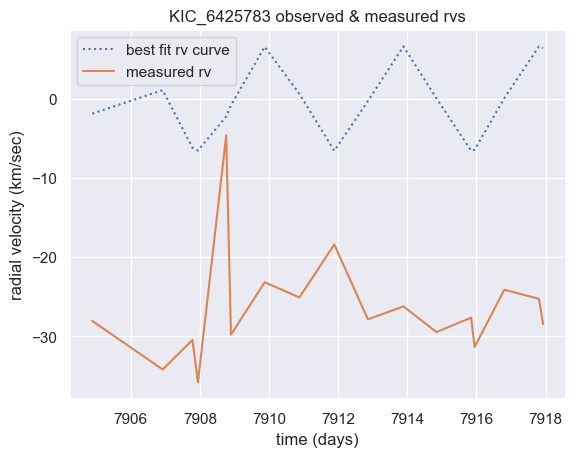

KIC target: KIC_6780052
max value is  1228.330366826287
min value is  34.025972407450475
theta value is  5.041038915587029 rad
q value is  0.16162853401278288
inclination angle value is  0.39449877485030216
Experimental p value =  [34.02597241]
Theoretical p value = 7.377758908227871
We do not have a binary system



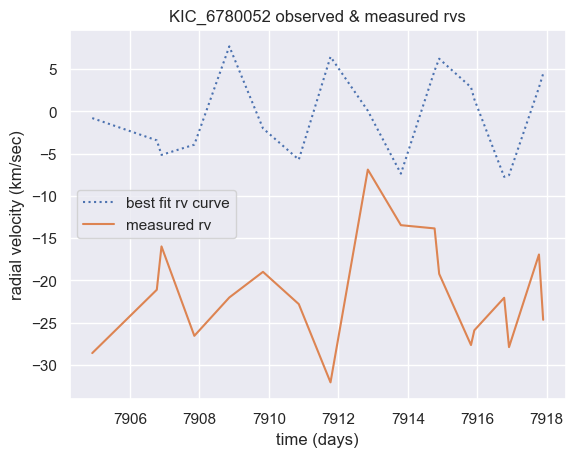

KIC target: KIC_6844101
max value is  1413.0529146910321
min value is  39.471251941152204
theta value is  1.6830720672920665 rad
q value is  0.06633401493549462
inclination angle value is  0.5264953732258066
Experimental p value =  [39.47125194]
Theoretical p value = 7.377758908227871
We do not have a binary system



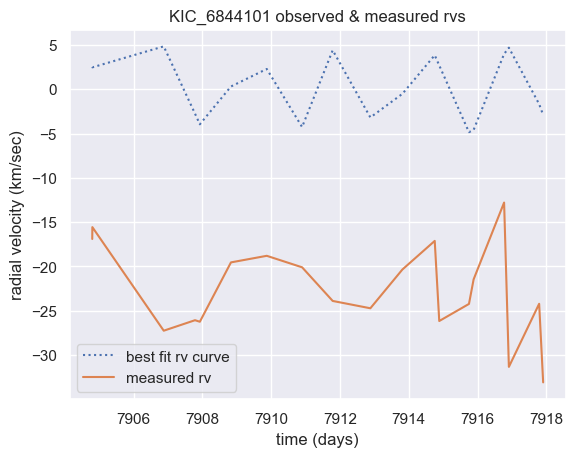

KIC target: KIC_7421325
max value is  946.7959540201967
min value is  12.525789770802364
theta value is  1.1052203137042809 rad
q value is  0.7566889825555867
inclination angle value is  0.23508303050241713
Experimental p value =  [12.52578977]
Theoretical p value = 7.377758908227871
We do not have a binary system



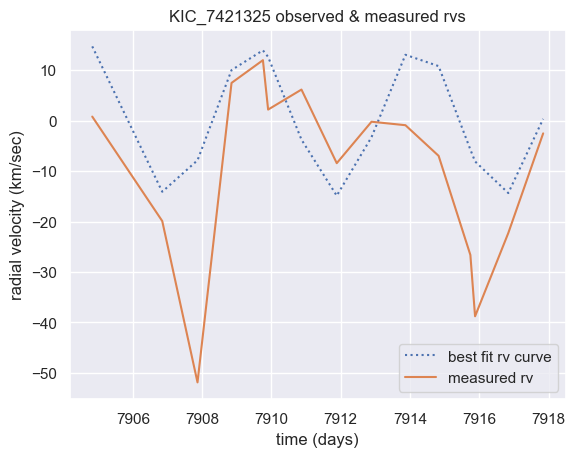

KIC target: KIC_7919763
max value is  1082.2534928790742
min value is  26.433462002743056
theta value is  5.294932024641329 rad
q value is  0.012294643619087386
inclination angle value is  0.8682934743096637
Experimental p value =  [26.433462]
Theoretical p value = 7.377758908227871
We do not have a binary system



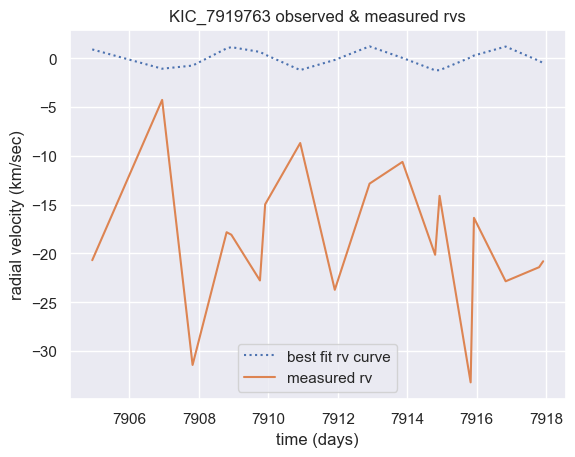

KIC target: KIC_8442720
max value is  1373.2245025832744
min value is  179.4470148297618
theta value is  5.279046796681283 rad
q value is  0.13266497942264988
inclination angle value is  0.6040478979053541
Experimental p value =  [179.44701483]
Theoretical p value = 7.377758908227871
We do not have a binary system



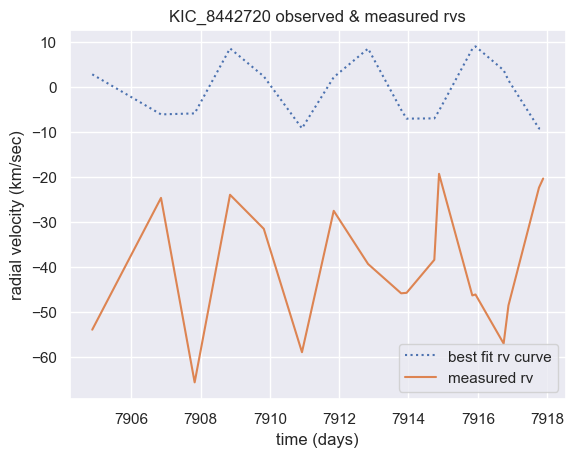

KIC target: KIC_8651471
max value is  889.6147573333793
min value is  2.175874312658697
theta value is  4.609331661794971 rad
q value is  0.04181253765617432
inclination angle value is  1.178528043634992
Experimental p value =  [2.17587431]
Theoretical p value = 7.377758908227871
We have a binary system



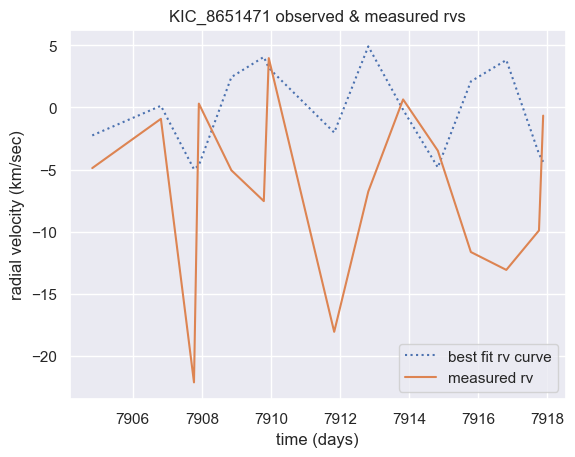

KIC target: KIC_9151271
max value is  3091.4309005873856
min value is  453.2100682806881
theta value is  3.2951610479366433 rad
q value is  0.579792001388289
inclination angle value is  0.23508303050241713
Experimental p value =  [453.21006828]
Theoretical p value = 7.377758908227871
We do not have a binary system



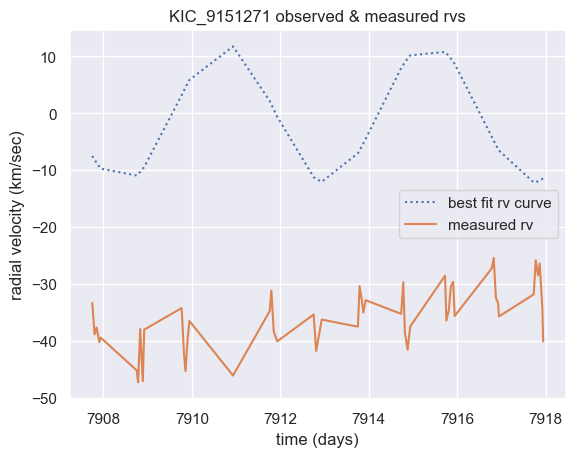

KIC target: KIC_9653110
max value is  1405.9336242948593
min value is  110.67357466357544
theta value is  1.661694799250738 rad
q value is  0.12595763918023906
inclination angle value is  1.3906206174919995
Experimental p value =  [110.67357466]
Theoretical p value = 7.377758908227871
We do not have a binary system



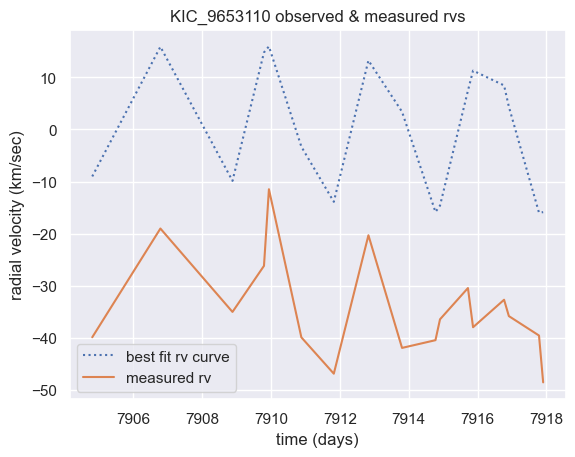

KIC target: KIC_9655045
max value is  362.68837645156685
min value is  0.008605983498686354
theta value is  1.8300021993897793 rad
q value is  0.18451892377921952
inclination angle value is  1.5247025724035879
Experimental p value =  [0.00860598]
Theoretical p value = 7.377758908227871
We have a binary system



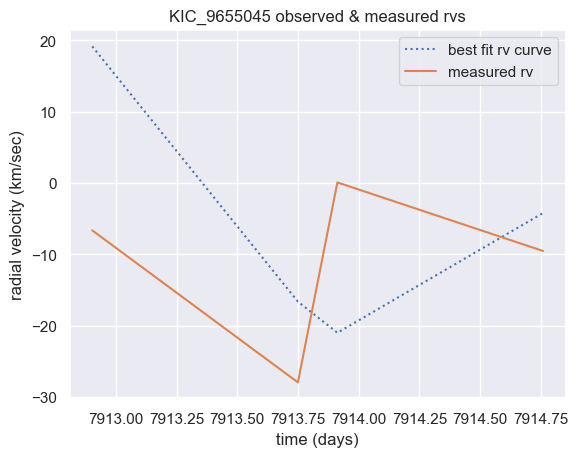

KIC target: KIC_9710336
max value is  1178.7587617517265
min value is  32.54309069554166
theta value is  1.7788620126023675 rad
q value is  0.13266497942264988
inclination angle value is  0.9361468405413637
Experimental p value =  [32.5430907]
Theoretical p value = 7.377758908227871
We do not have a binary system



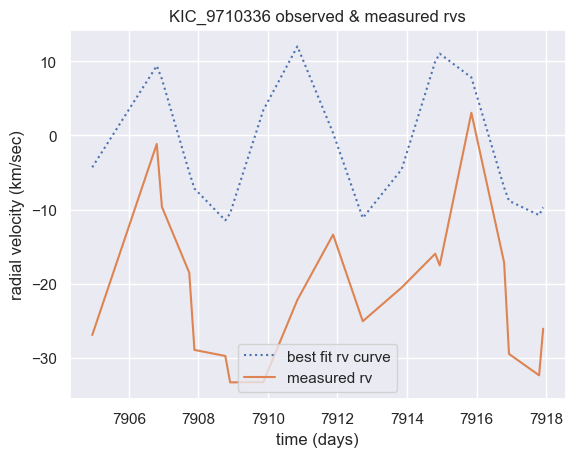

KIC target: KIC_9964938
max value is  1086.191099570378
min value is  1.9705626949798998
theta value is  3.53371093998375 rad
q value is  0.03178143766179076
inclination angle value is  1.1679162835161012
Experimental p value =  [1.97056269]
Theoretical p value = 7.377758908227871
We have a binary system



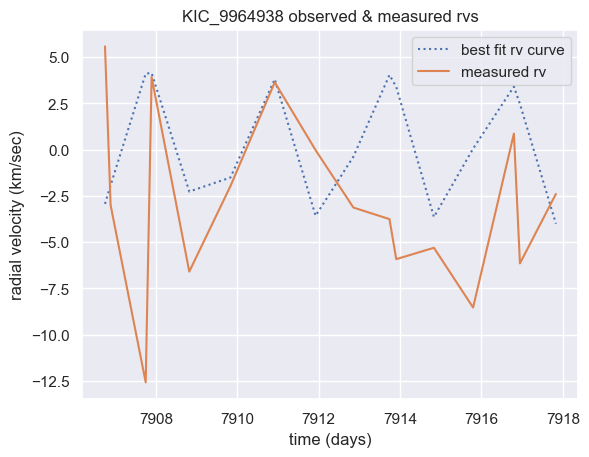

KIC target: KIC_11819949
max value is  1509.3992791927687
min value is  4.087213410648002
theta value is  0.4174575636282581 rad
q value is  0.21735139752320798
inclination angle value is  0.35243231745848297
Experimental p value =  [4.08721341]
Theoretical p value = 7.377758908227871
We have a binary system



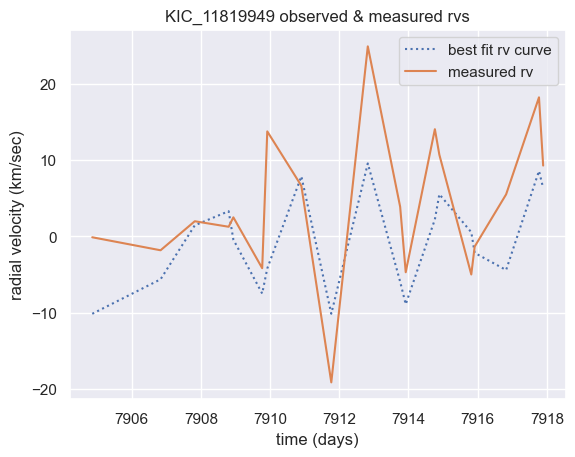

KIC target: KIC_12736892
max value is  1167.4863402864105
min value is  3.039365576279885
theta value is  6.096086631764203 rad
q value is  0.1674291589764314
inclination angle value is  0.9074578137285263
Experimental p value =  [3.03936558]
Theoretical p value = 7.377758908227871
We have a binary system



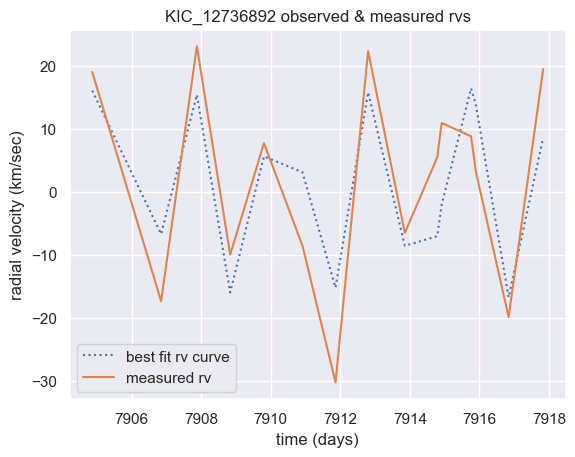

In [12]:
Run_Model()